# Specifying a measurement layout

This document shows you how to deal with circuit layout in different cases.

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Transpiled Quantum Circuit

Example of a quantum circuit without ancilla qubits before transpilation.

### Define quantum circuit

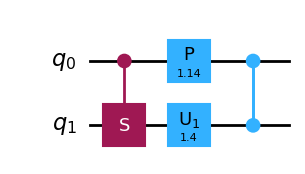

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.random import random_circuit

qc = random_circuit(2, 3, seed=786446)
qc.draw("mpl", style="iqp")

### Transpile circuit

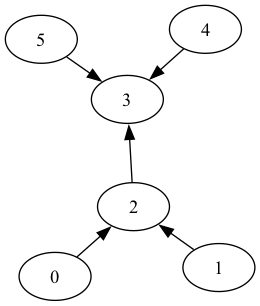

In [3]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Generate a 5-qubit simulated backend
backend = GenericBackendV2(num_qubits=6, coupling_map=[[0, 2], [1, 2], [2, 3], [4, 3], [5, 3]])

backend.set_options(seed_simulator=25)
pm = generate_preset_pass_manager(optimization_level=2, backend=backend)

coupling_map = backend.coupling_map
coupling_map.draw()

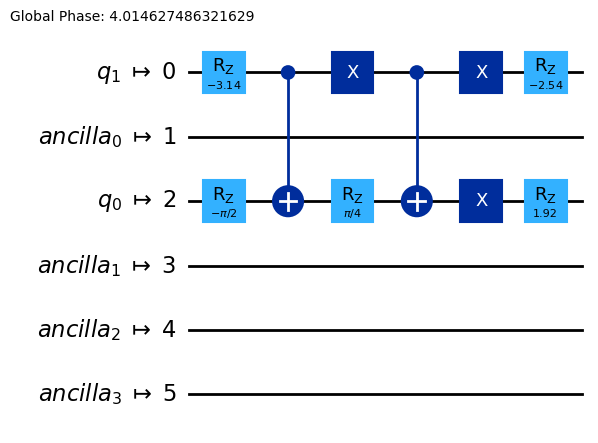

In [4]:
# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit.
# Note: the transpiler automatically adds "ancilla" qubits to make the transpiled
# circuit match the size of the FakeManilaV2 backend.
qc_isa = pm.run(qc)
qc_isa.draw("mpl", style="iqp")

### Define measurement procedure

No need to set a particular `measurement_layout`, because the `POVMSampler` will analyze the transpiled circuit and apply the `TranspileLayout` to the measurement circuit.

In [5]:
import numpy as np
from povm_toolbox.library.dilation_measurement import DilationMeasurements

measurement = DilationMeasurements(
    num_qubits=2,
    parameters=np.array(
        [0.75, 0.30408673, 0.375, 0.40678524, 0.32509973, 0.25000035, 0.49999321, 0.83333313]
    ),
)

More precisely, the measurement layout that will be automatically applied by the `POVMSampler` is extracted as :
```python
transpile_layout = transpiled_circuit.layout
measurement_layout = transpile_layout.final_index_layout(filter_ancillas=True)
```
For the above circuit, we have:

In [6]:
print(qc_isa.layout.final_index_layout(filter_ancillas=True))

[2, 0]


### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [7]:
from povm_toolbox.sampler import POVMSampler
from qiskit_ibm_runtime import SamplerV2 as RuntimeSampler

# First define a standard sampler (that will be used under the hood).
runtime_sampler = RuntimeSampler(mode=backend)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(runtime_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
job = povm_sampler.run([qc_isa], shots=4096, povm=measurement, pass_manager=pm)

Look at the final composed circuit to check that the measurement was performed on the correct qubits.

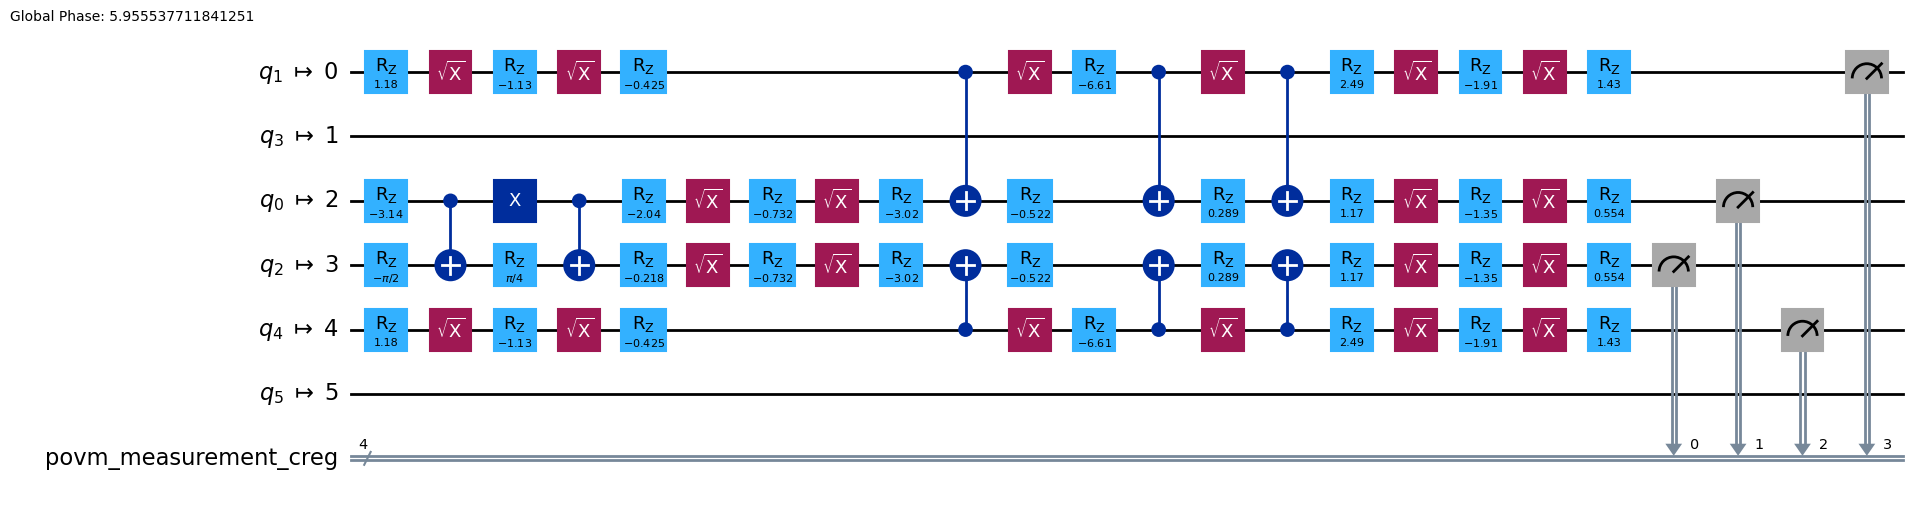

In [8]:
pub_result = job.result()[0]
pub_result.metadata.composed_circuit.draw("mpl", style="iqp")

### Define observable

In [9]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp(["XI", "XX", "YY", "ZX"], coeffs=[1, 1, -1, 1])

### Get the expected value

The observable has to be specified in terms of virtual qubits. Therefore, there is no need to apply the layout that was used by the POVM on the physical qubits.

In [10]:
from povm_toolbox.post_processor import POVMPostProcessor

post_processor = POVMPostProcessor(pub_result)
exp_value, std = post_processor.get_expectation_value(observable)
print(exp_value)

0.059453347400905215


For reference, we can compare our estimated expectation value to the exact value.


In [11]:
from qiskit.quantum_info import Statevector

isa_observable = observable.apply_layout(layout=qc_isa.layout, num_qubits=qc_isa.num_qubits)

exact_expectation_value = np.real_if_close(Statevector(qc_isa).expectation_value(isa_observable))
print(f"Exact value:     {exact_expectation_value}")
print(f"Estimated value: {exp_value}")

Exact value:     0.0
Estimated value: 0.059453347400905215


## 2. Quantum Circuit with ancilla qubits

Example of an un-transpiled quantum circuit with ancilla qubits 

### Define quantum circuit
The circuit can contain some ancilla qubits that you might not want to measure.

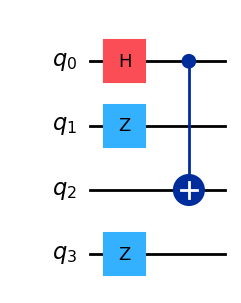

In [12]:
qc_with_ancilla_1 = QuantumCircuit(4)

# Qubits (0,2):
qc_with_ancilla_1.h(0)
qc_with_ancilla_1.cx(0, 2)

# Ancilla qubits (1,3):
qc_with_ancilla_1.z(1)
qc_with_ancilla_1.z(3)

qc_with_ancilla_1.draw("mpl", style="iqp")

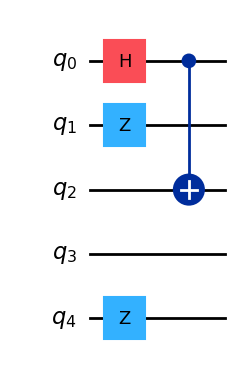

In [13]:
qc_with_ancilla_2 = QuantumCircuit(5)


# Qubits (0,2):
qc_with_ancilla_2.h(0)
qc_with_ancilla_2.cx(0, 2)

# Ancilla qubits (1,4):
qc_with_ancilla_2.z(1)
qc_with_ancilla_2.z(4)

qc_with_ancilla_2.draw("mpl", style="iqp")

### Define measurement procedure

The `measurement_layout` argument specifies which qubits to measure. It can be seen as a map from virtual to physical qubits indices. In this example, we only want to measure qubits 1 and 3.

In [14]:
# The first local POVM will act on physical qubit 1 and the second local POVM will act on physical qubit 3.

measurement = DilationMeasurements(
    num_qubits=2,
    measurement_layout=[0, 2],
    parameters=np.array(
        [0.75, 0.30408673, 0.375, 0.40678524, 0.32509973, 0.25000035, 0.49999321, 0.83333313]
    ),
)

### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [15]:
from numpy.random import default_rng
from qiskit.primitives import StatevectorSampler

rng = default_rng(26)

sampler = StatevectorSampler(seed=rng)
povm_sampler = POVMSampler(sampler=sampler)

job = povm_sampler.run([qc_with_ancilla_1, qc_with_ancilla_2], shots=4096, povm=measurement)
result = job.result()
pub_result = result[0]

Look at the final composed circuit to check that the measurement was performed on the correct qubits.

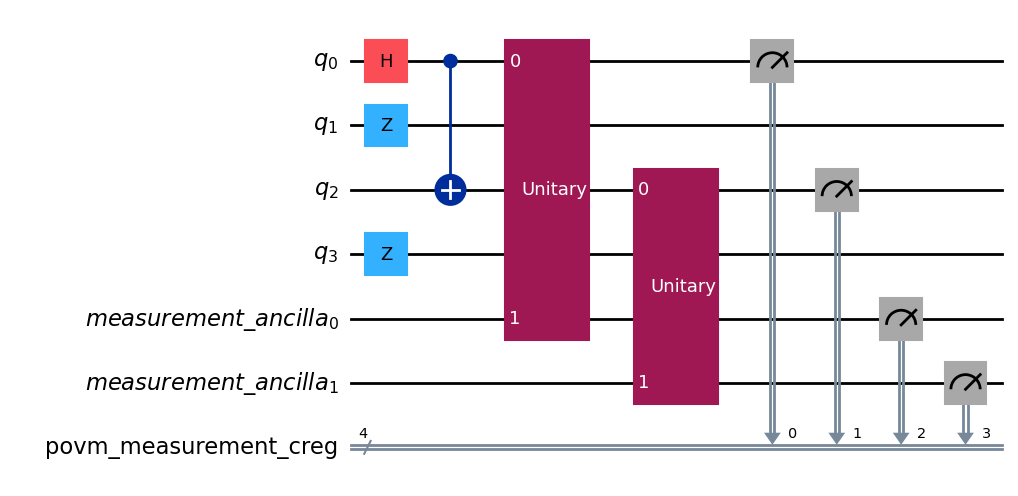

In [16]:
pub_result.metadata.composed_circuit.draw("mpl")

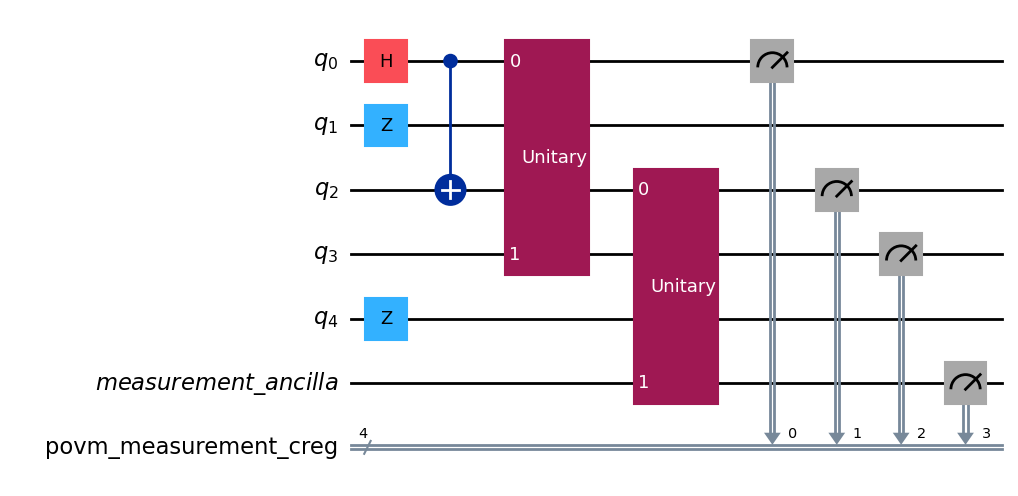

In [17]:
result[1].metadata.composed_circuit.draw("mpl")

### Get the expected value

The observable has to be specified in terms of virtual qubits. Therefore, there is no need to apply the layout that was used by the POVM on the full register of qubits.

In [18]:
post_processor = POVMPostProcessor(pub_result)

observable_layout_02 = SparsePauliOp(["IXII", "IXIX", "IYIY", "IZIX"], coeffs=[1, 1, -1, 1])

exact_expectation_value = np.real_if_close(
    Statevector(qc_with_ancilla_1).expectation_value(observable_layout_02)
)
print(f"Exact value:     {exact_expectation_value}")

exp_value, std = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value}")

Exact value:     1.9999999999999996
Estimated value: 1.9924532054369224


## 3. Transpiled Quantum Circuit with ancilla qubits

Example where the quantum circuit had ancilla qubits before transpilation.

### Transpile circuit with ancilla qubits

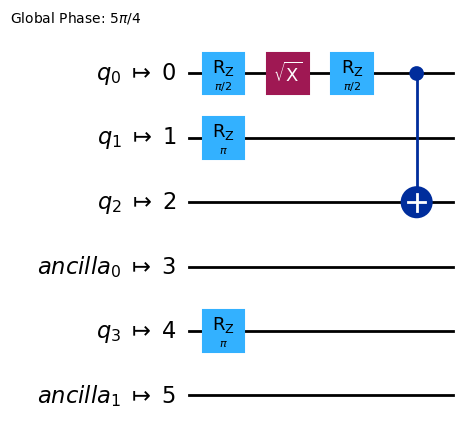

In [19]:
# Transpile the circuit to an "Instruction Set Architecture" (ISA) circuit
qc_with_ancilla_isa = pm.run(qc_with_ancilla_1)
qc_with_ancilla_isa.draw("mpl", style="iqp")

### Define measurement procedure

The `measurement_layout` argument specifies which qubits to measure. This argument overrides the automatic detection of a possible `TranspileLayout` attribute of the supplied circuit. I.e., it specifies directly the (final) physical qubits on which the POVM will act. In this example, we want to measure physical qubits 4 and 3.

If you want to specify the virtual qubits instead (here virtual qubits 1 and 3), you have to do the composition with the `TranspileLayout` manually as follows:

In [20]:
# Measuring virtual qubits 0 and 2
virtual_msmt_layout = [0, 2]
# Get the transpilation layout
transpile_layout = qc_with_ancilla_isa.layout.final_index_layout()
# Compute the final measurement layout
final_msmt_layout = [transpile_layout[idx] for idx in virtual_msmt_layout]
print("Final measurement layout:", final_msmt_layout)

measurement = DilationMeasurements(
    2,
    measurement_layout=final_msmt_layout,
    parameters=np.array(
        [0.75, 0.30408673, 0.375, 0.40678524, 0.32509973, 0.25000035, 0.49999321, 0.83333313]
    ),
)

Final measurement layout: [0, 2]


### Run the job

Initialize `Sampler` and `POVMSampler`. Then run the job.

In [21]:
# First define a standard sampler (that will be used under the hood).
runtime_sampler = RuntimeSampler(mode=backend)
# Then define the POVM sampler, which takes BaseSampler as an argument.
povm_sampler = POVMSampler(runtime_sampler)
# Submit the job by specifying which POVM to use, which circuit(s) to measure and the shot budget.
job = povm_sampler.run([qc_with_ancilla_isa], shots=4096, povm=measurement, pass_manager=pm)
pub_result = job.result()[0]

You can check that measurement was performed on the correct physical qubits by looking at the final composed circuit.

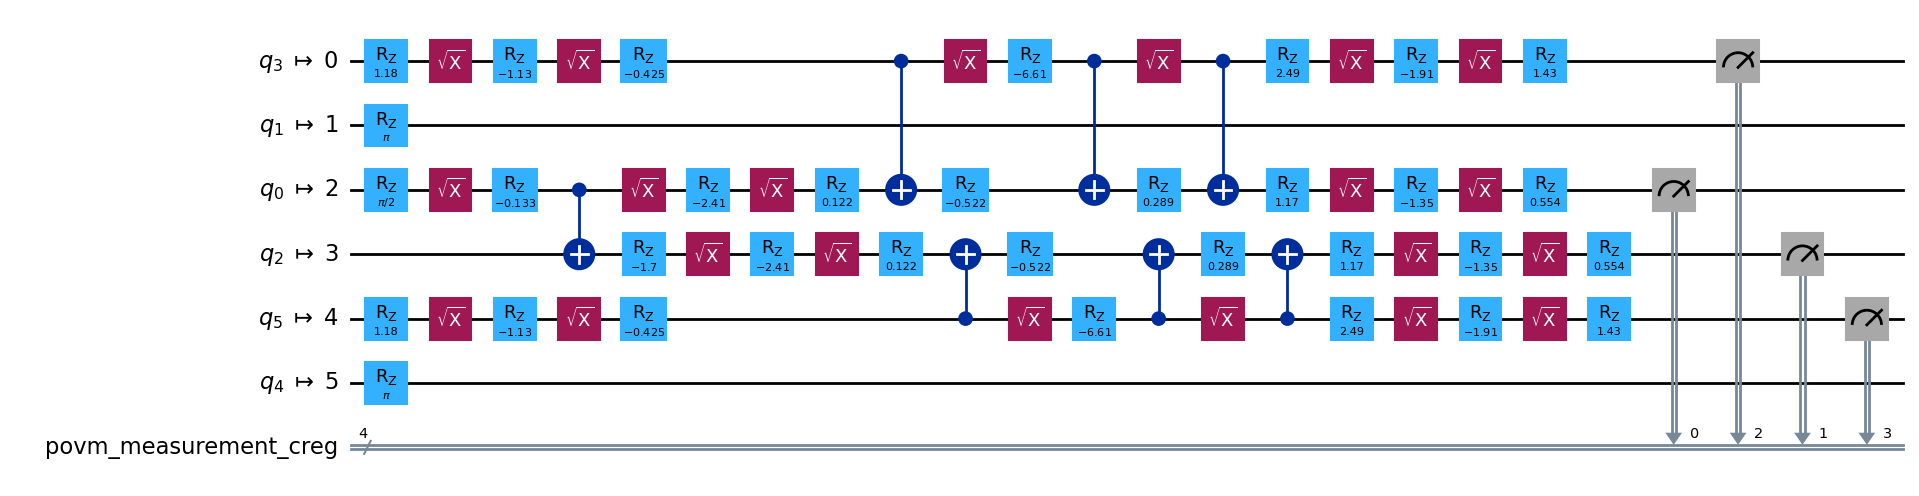

In [22]:
pub_result.metadata.composed_circuit.draw("mpl", style="iqp")

### Get the expected value

The observable has to be specified in terms of virtual qubits. Therefore, there is no need to apply the layout that was used by the POVM on the physical qubits.

In [23]:
post_processor = POVMPostProcessor(pub_result)

print(f"Exact value:     {exact_expectation_value}")

exp_value, std = post_processor.get_expectation_value(observable)
print(f"Estimated value: {exp_value}")

Exact value:     1.9999999999999996
Estimated value: 2.006639958501409
